# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


#### Set up Hyperparameters 
In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
#
# original code - to be uncommented before submission
train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
#
# added code - comment/delete before submission
#train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
#

batch_size = 32 #experiment with the batch size
num_epochs = 50 # choose the number of epochs
img_frames_tot = 30 # this is the total number of frames we have per video
img_feed_factor = 1  # to decide on number of frames to feed for each video, use img_feed_factor 
img_frames = int(img_frames_tot / img_feed_factor) # to be passed to model to specify # of frames per video.
img_ht = 120
img_wd = 120

decay_factor = 0.5

# setup image normalization type 
#     0 - simple (divide by 255)
#     1 - max norm (using sklearn)
#     2 - min-max norm
#     3 - percentile based
norm_type_dic = {0:'simple', 1:'max', 2:'min-max', 3:'mean'}
norm_type = 0



## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = [x for x in range(0,img_frames_tot) if int(x%img_feed_factor)==0] 
        
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,len(img_idx),img_ht,img_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    #since the given input is of images will be 160*120 and 360*360
                    if image.shape[0]!=image.shape[1]:
                        image=image[0:120,20:140]

                    #resize the image 120*120
                    img_resized = imresize(image, (img_ht,img_wd), interp = 'nearest')

                    if (norm_type==0):
                    #Simple Normalisation
                        batch_data[folder,idx,:,:,0] = img_resized[:,:,0]/255
                        batch_data[folder,idx,:,:,1] = img_resized[:,:,1]/255
                        batch_data[folder,idx,:,:,2] = img_resized[:,:,2]/255
                    elif (norm_type==2):
                    #Min-Max normalisation
                        img_min = np.min(img_resized)
                        img_max = np.max(img_resized)
                        batch_data[folder,idx,:,:,0] = (img_resized[:,:,0] - img_min) / (img_max - img_min)  
                        batch_data[folder,idx,:,:,1] = (img_resized[:,:,1] - img_min) / (img_max - img_min)
                        batch_data[folder,idx,:,:,2] = (img_resized[:,:,2] - img_min) / (img_max - img_min)
                    elif(norm_type==3):
                    #mean & stddev based normalisation
                        img_mean = np.mean(img_resized)
                        img_std = np.std(img_resized)
                        batch_data[folder,idx,:,:,0] = (img_resized[:,:,0] - img_mean) / img_std  
                        batch_data[folder,idx,:,:,1] = (img_resized[:,:,1] - img_mean) / img_std
                        batch_data[folder,idx,:,:,2] = (img_resized[:,:,2] - img_mean) / img_std


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels
            
        # write the code for the remaining data points which are left after full batches
        remaining_videos=len(folder_list)%batch_size
        if(remaining_videos>0):
            
            batch_data = np.zeros((batch_size,len(img_idx),img_ht,img_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    #since the given input is of images will be 160*120 and 360*360
                    if image.shape[0]!=image.shape[1]:
                        image=image[0:120,20:140]

                    #resize the image 120*120
                    img_resized = imresize(image, (img_ht,img_wd), interp = 'nearest')

                    if (norm_type==0):
                    #Simple Normalisation
                        batch_data[folder,idx,:,:,0] = img_resized[:,:,0]/255
                        batch_data[folder,idx,:,:,1] = img_resized[:,:,1]/255
                        batch_data[folder,idx,:,:,2] = img_resized[:,:,2]/255
                    elif (norm_type==2):
                    #Min-Max normalisation
                        img_min = np.min(img_resized)
                        img_max = np.max(img_resized)
                        batch_data[folder,idx,:,:,0] = (img_resized[:,:,0] - img_min) / (img_max - img_min)  
                        batch_data[folder,idx,:,:,1] = (img_resized[:,:,1] - img_min) / (img_max - img_min)
                        batch_data[folder,idx,:,:,2] = (img_resized[:,:,2] - img_min) / (img_max - img_min)
                    elif(norm_type==3):
                    #mean & stddev based normalisation
                        img_mean = np.mean(img_resized)
                        img_std = np.std(img_resized)
                        batch_data[folder,idx,:,:,0] = (img_resized[:,:,0] - img_mean) / img_std  
                        batch_data[folder,idx,:,:,1] = (img_resized[:,:,1] - img_mean) / img_std
                        batch_data[folder,idx,:,:,2] = (img_resized[:,:,2] - img_mean) / img_std

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels
          


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()

# original code - to be uncommented before submission
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
# added code - comment/delete before submission
#train_path = './Project_data/train'
#val_path = './Project_data/val'
#

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


### Testing the generator

In [7]:
train_generator = generator(train_path, train_doc, batch_size)


print('normalisation:', norm_type_dic[norm_type])
bdata, blabels = next(train_generator)
print('batch data mean:', np.mean(bdata))



normalisation: simple
Source path =  ./Project_data/train ; batch size = 32
batch data mean: 0.4387791173066453
batch labels mean: 0.2


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
#from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


#### Model #1 - Conv 3D 


In [9]:
#write your model here


model = Sequential()

model.add(Conv3D(8, kernel_size=(3, 3, 3),padding='same',input_shape=(img_frames,img_ht,img_wd,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))     
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1, 3, 3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))     
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1, 3, 3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))     
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.5))
               
#Flattern
model.add(Flatten())
          
#Dense layers

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))          


#Soft Max Layer
model.add(Dense(5, activation='softmax'))




Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
from keras.optimizers import Adam
optimiser = Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
# 'model_init' is just example text for the name. Replace that with any appropriate name you want.
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'model_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=decay_factor, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Display Values of various hyperparameters

In [14]:
print('Frames per video:', img_frames)
print('Epochs:', num_epochs)
print('Batch Size:',batch_size)
print('Decay Factor:',decay_factor)
print('Normalization Type:', norm_type_dic[norm_type])



Frames per video: 30
Epochs: 50
Batch Size: 32
Decay Factor: 0.5
Normalization Type: simple


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
#
# train_generator: generator object created above 
# steps_per_epoch: # of batch calls the fit_generator needs to make so as to complete one pass over the entire dataset
# num_epochs: typically between 50 & 100 depending upon the LR (Learning Rate)
# callbacks_list: already specified above (checkpoint & LR). fit_generator will, at the end of every epoch, perform the actions listed here.
# validation_data: generated above.
# class_weight: no need to worry since we have been provided with balanced data
# workers: a way to parallelize data-fetching & model-computation 
# 
btime = datetime.datetime.now()
print('Time@Begin:',btime)

'''
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
'''
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


etime = datetime.datetime.now()
print('Time@End:', etime)
print('Elapsed Time:', etime-btime)


Time@Begin: 2019-12-23 12:26:05.519052
Source path =  ./Project_data/val ; batch size = Source path =  ./Project_data/train ; batch size = 32
Epoch 1/5032

21/21 [==============================] - 177s 8s/step - loss: 1.9246 - categorical_accuracy: 0.3199 - val_loss: 1.2497 - val_categorical_accuracy: 0.4531

Epoch 00001: saving model to model_1_2019-12-2312_25_55.208840/model-00001-1.92461-0.31994-1.24973-0.45312.h5
Epoch 2/50
21/21 [==============================] - 76s 4s/step - loss: 1.2821 - categorical_accuracy: 0.4122 - val_loss: 1.3223 - val_categorical_accuracy: 0.3672

Epoch 00002: saving model to model_1_2019-12-2312_25_55.208840/model-00002-1.28211-0.41220-1.32231-0.36719.h5
Epoch 3/50
21/21 [==============================] - 72s 3s/step - loss: 1.1585 - categorical_accuracy: 0.4717 - val_loss: 1.0660 - val_categorical_accuracy: 0.5234

Epoch 00003: saving model to model_1_2019-12-2312_25_55.208840/model-00003-1.15854-0.47173-1.06596-0.52344.h5
Epoch 4/50
21/21 [===========

21/21 [==============================] - 72s 3s/step - loss: 0.4717 - categorical_accuracy: 0.8110 - val_loss: 0.5196 - val_categorical_accuracy: 0.8125

Epoch 00029: saving model to model_1_2019-12-2312_25_55.208840/model-00029-0.47165-0.81101-0.51958-0.81250.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 30/50
21/21 [==============================] - 73s 3s/step - loss: 0.4723 - categorical_accuracy: 0.8036 - val_loss: 0.4982 - val_categorical_accuracy: 0.8203

Epoch 00030: saving model to model_1_2019-12-2312_25_55.208840/model-00030-0.47232-0.80357-0.49822-0.82031.h5
Epoch 31/50
21/21 [==============================] - 72s 3s/step - loss: 0.4540 - categorical_accuracy: 0.8333 - val_loss: 0.5409 - val_categorical_accuracy: 0.7969

Epoch 00031: saving model to model_1_2019-12-2312_25_55.208840/model-00031-0.45404-0.83333-0.54090-0.79688.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 32/50
21/21 [==

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


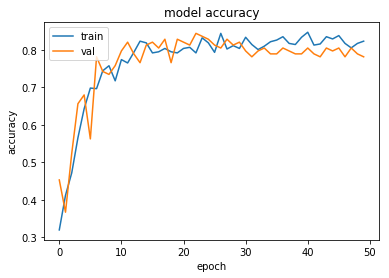

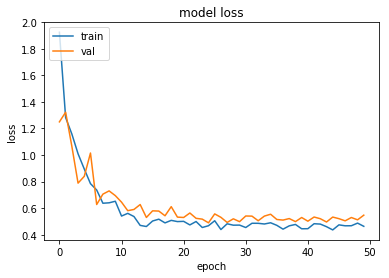

In [17]:
  #import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
